<a href="https://colab.research.google.com/github/Naomi-Ken-Korem/text-to-image-datatalks/blob/main/Glide_text2image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Glide -300M model 

## Text to image



In [ ]:
!pip install git+https://github.com/openai/glide-text2im

In [ ]:
from PIL import Image
from IPython.display import display
import torch
import numpy as np

from glide_text2im.download import load_checkpoint
from glide_text2im.model_creation import (
    create_model_and_diffusion,
    model_and_diffusion_defaults,
)

In [ ]:
# This notebook supports both CPU and GPU.
# On CPU, generating one sample may take on the order of 20 minutes.
# On a GPU, it should be under a minute.

has_cuda = torch.cuda.is_available()
device = torch.device('cpu' if not has_cuda else 'cuda')

Now lets load glide 300 model

In [ ]:
# Create base model.
options = model_and_diffusion_defaults()
options['use_fp16'] = has_cuda
options['timestep_respacing'] = '50' # use 100 diffusion steps for fast sampling
model, diffusion = create_model_and_diffusion(**options)
model.eval()
if has_cuda:
    model.convert_to_fp16()
model.to(device)
model.load_state_dict(load_checkpoint('base', device))


This model is called Glide 300M. Lets see the size of the model

In [ ]:
print('total base parameters', sum(x.numel() for x in model.parameters()))

total base parameters 385030726


In [ ]:
def show_images(batch: torch.Tensor):
    """ Display a batch of images inline. """
    scaled = ((batch + 1)*127.5).round().clamp(0,255).to(torch.uint8).cpu()
    reshaped = scaled.permute(2, 0, 3, 1).reshape([batch.shape[2], -1, 3])
    display(Image.fromarray(reshaped.numpy()).resize((256,256)))

### Sampling methods
You can avoid this part ,but if you want to see in detailes how the iterative sampling works, check it out

In [ ]:
from glide_text2im.gaussian_diffusion import _extract_into_tensor
def p_mean_variance(self, model, x, t, clip_denoised=True, denoised_fn=None, model_kwargs=None):
    """
    Apply the model to get p(x_{t-1} | x_t), as well as a prediction of
    the initial x, x_0.
    :param model: the model, which takes a signal and a batch of timesteps
                  as input.
    :param x: the [N x C x ...] tensor at time t.
    :param t: a 1-D Tensor of timesteps.
    :param clip_denoised: if True, clip the denoised signal into [-1, 1].
    :param denoised_fn: if not None, a function which applies to the
        x_start prediction before it is used to sample. Applies before
        clip_denoised.
    :param model_kwargs: if not None, a dict of extra keyword arguments to
        pass to the model. This can be used for conditioning.
    :return: a dict with the following keys:
              - 'mean': the model mean output.
              - 'variance': the model variance output.
              - 'log_variance': the log of 'variance'.
              - 'pred_xstart': the prediction for x_0.
    """
    model = self._wrap_model(model) #respace diffusion steps
    if model_kwargs is None:
        model_kwargs = {}

    B, C = x.shape[:2]
    assert t.shape == (B,)
    model_output = model(x, t, **model_kwargs)
    if isinstance(model_output, tuple):
        model_output, extra = model_output
    else:
        extra = None

    assert model_output.shape == (B, C * 2, *x.shape[2:])
    model_output, model_var_values = torch.split(model_output, C, dim=1)
    min_log = _extract_into_tensor(self.posterior_log_variance_clipped, t, x.shape)
    max_log = _extract_into_tensor(np.log(self.betas), t, x.shape)
    # The model_var_values is [-1, 1] for [min_var, max_var].
    frac = (model_var_values + 1) / 2
    model_log_variance = frac * max_log + (1 - frac) * min_log
    model_variance = torch.exp(model_log_variance)

    def process_xstart(x):
        if denoised_fn is not None:
            x = denoised_fn(x)
        if clip_denoised:
            return x.clamp(-1, 1)
        return x

    pred_xstart = process_xstart(self._predict_xstart_from_eps(x_t=x, t=t, eps=model_output))
    model_mean, _, _ = self.q_posterior_mean_variance(x_start=pred_xstart, x_t=x, t=t)

    assert model_mean.shape == model_log_variance.shape == pred_xstart.shape == x.shape
    return {
        "mean": model_mean,
        "variance": model_variance,
        "log_variance": model_log_variance,
        "pred_xstart": pred_xstart,
        "extra": extra,
    }

def p_sample(
    diffusion_model,
    model,
    x,
    t,
    clip_denoised=True,
    denoised_fn=None,
    cond_fn=None,
    model_kwargs=None,
):
    """
    Sample x_{t-1} from the model at the given timestep.
    :param model: the model to sample from.
    :param x: the current tensor at x_{t-1}.
    :param t: the value of t, starting at 0 for the first diffusion step.
    :param clip_denoised: if True, clip the x_start prediction to [-1, 1].
    :param denoised_fn: if not None, a function which applies to the
        x_start prediction before it is used to sample.
    :param cond_fn: if not None, this is a gradient function that acts
                    similarly to the model.
    :param model_kwargs: if not None, a dict of extra keyword arguments to
        pass to the model. This can be used for conditioning.
    :return: a dict containing the following keys:
              - 'sample': a random sample from the model.
              - 'pred_xstart': a prediction of x_0.
    """
    out = p_mean_variance(
        diffusion_model,
        model,
        x,
        t,
        clip_denoised=clip_denoised,
        denoised_fn=denoised_fn,
        model_kwargs=model_kwargs,
    )
    noise = torch.randn_like(x)
    nonzero_mask = (
        (t != 0).float().view(-1, *([1] * (len(x.shape) - 1)))
    )  # no noise when t == 0
    sample = out["mean"] + nonzero_mask * torch.exp(0.5 * out["log_variance"]) * noise
    return {"sample": sample, "pred_xstart": out["pred_xstart"]}

def p_sample_loop(
    diffusion_model,
    model,
    shape,
    noise=None,
    clip_denoised=True,
    denoised_fn=None,
    cond_fn=None,
    model_kwargs=None,
    device=None,
    progress=False,
):
    """
    Generate samples from the model.
    :param model: the model module.
    :param shape: the shape of the samples, (N, C, H, W).
    :param noise: if specified, the noise from the encoder to sample.
                  Should be of the same shape as `shape`.
    :param clip_denoised: if True, clip x_start predictions to [-1, 1].
    :param denoised_fn: if not None, a function which applies to the
        x_start prediction before it is used to sample.
    :param cond_fn: if not None, this is a gradient function that acts
                    similarly to the model.
    :param model_kwargs: if not None, a dict of extra keyword arguments to
        pass to the model. This can be used for conditioning.
    :param device: if specified, the device to create the samples on.
                    If not specified, use a model parameter's device.
    :param progress: if True, show a tqdm progress bar.
    :return: a non-differentiable batch of samples.
    """
    final = None
    for sample in p_sample_loop_progressive(
        diffusion_model,
        model,
        shape,
        noise=noise,
        clip_denoised=clip_denoised,
        denoised_fn=denoised_fn,
        cond_fn=cond_fn,
        model_kwargs=model_kwargs,
        device=device,
        progress=progress,
    ):
        final = sample
    return final["sample"]

def p_sample_loop_progressive(
    diffusion_model,
    model,
    shape,
    noise=None,
    clip_denoised=True,
    denoised_fn=None,
    cond_fn=None,
    model_kwargs=None,
    device=None,
    progress=False,
):
    """
    Generate samples from the model and yield intermediate samples from
    each timestep of diffusion.
    Arguments are the same as p_sample_loop().
    Returns a generator over dicts, where each dict is the return value of
    p_sample().
    """
    if device is None:
        device = next(model.parameters()).device
    assert isinstance(shape, (tuple, list))
    if noise is not None:
        img = noise
    else:
        img = torch.randn(*shape, device=device)
    indices = list(range(diffusion_model.num_timesteps))[::-1]

    if progress:
        # Lazy import so that we don't depend on tqdm.
        from tqdm.auto import tqdm

        indices = tqdm(indices)

    for i in indices:
        t = torch.tensor([i] * shape[0], device=device)
        with torch.no_grad():
            out = p_sample(
                diffusion_model,
                model,
                img,
                t,
                clip_denoised=clip_denoised,
                denoised_fn=denoised_fn,
                cond_fn=cond_fn,
                model_kwargs=model_kwargs,
            )
            yield out
            img = out["sample"]

### Now lets run the diffusion sampling process

In [ ]:
# You can try to set different prompts here
prompt = "an oil painting of a corgi"

batch_size = 1


Create the text tokens to feed to the model.
Text prompts should be first tokanized, then it will go through attention modul inside glide model.

  0%|          | 0/50 [00:00<?, ?it/s]

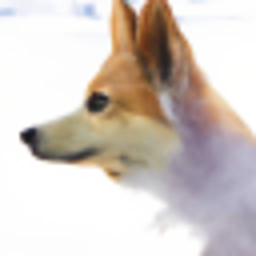

In [ ]:
tokens = model.tokenizer.encode(prompt)
tokens, mask = model.tokenizer.padded_tokens_and_mask(
    tokens, options['text_ctx']
)


# Pack the tokens together into model kwargs.
model_kwargs = dict(
    tokens=torch.tensor(
        [tokens] * batch_size, device=device
    ),
    mask=torch.tensor(
        [mask] * batch_size,
        dtype=torch.bool,
        device=device,
    ),
)


# Sample from the base model.
model.del_cache()
samples = diffusion.p_sample_loop(
    model,
    (batch_size, 3, options["image_size"], options["image_size"]),
    device=device,
    clip_denoised=True,
    progress=True,
    model_kwargs=model_kwargs,
)[:batch_size]
model.del_cache()

# Show the output
show_images(samples)

### Class free guidance



This result is nice, but lets try to apply the class free gudiance trick.

Try to do it yourself.

On each diffusion steps, the model is applied twice, 

once given the original prompt $\mathbf{x}_{prompt}$, 

and the second one with an empty prompt $\mathbf{x}_{empty}$. 


The step result is updated to be: 

${x} = \mathbf{x}_{empty} + guidance scale * (\mathbf{x}_{prompt} - \mathbf{x}_{empty})$
   
Note That the model can run only once on a batch consiting a sample with the text condition, and on a sample with an empty text condition

In [ ]:
guidance_scale = 5.0 #You can set different values here, to see what works better


# propmt tokens already defined, now lets create the empty tokens:
uncond_tokens, uncond_mask = model.tokenizer.padded_tokens_and_mask(
    [], options['text_ctx']
)


In [ ]:
full_batch_size = batch_size * 2

# Pack the tokens together into model kwargs.
model_kwargs = dict(
    tokens=torch.tensor(
        [tokens] * batch_size + [uncond_tokens] * batch_size, device=device
    ),
    mask=torch.tensor(
        [mask] * batch_size + [uncond_mask] * batch_size,
        dtype=torch.bool,
        device=device,
    ),
)

Lets overide the model.forward() with classifier_free_guidance_step that will apply the guidance trick:
After each step of getting the model prediction on both conditions, the prompt, and the empty, we have to update the noise using the guidance scale:
${x} = \mathbf{x}_{empty} + guidance scale * (\mathbf{x}_{prompt} - \mathbf{x}_{empty})$

In [ ]:
# Create a classifier-free guidance sampling function
def classifier_free_guidance_step(x_t, ts, **kwargs):
    half = x_t[: len(x_t) // 2]
    combined = torch.cat([half, half], dim=0)
    model_out = model(combined, ts, **kwargs)
    eps, rest = model_out[:, :3], model_out[:, 3:]
    eps_prompt, eps_empty = torch.split(eps, len(eps) // 2, dim=0)
    guided_eps = #your code goes here
    eps = torch.cat([guided_eps, guided_eps], dim=0)
    return torch.cat([eps, rest], dim=1)

Sample the result with the overrided function, instead of the original model:

  0%|          | 0/50 [00:00<?, ?it/s]

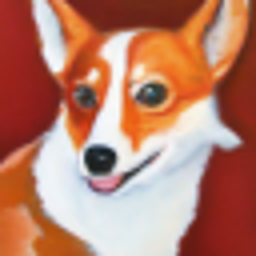

In [ ]:
# Sample from the base model.
model.del_cache()
samples = diffusion.p_sample_loop(
    classifier_free_guidance_step,
    (full_batch_size, 3, options["image_size"], options["image_size"]),
    device=device,
    clip_denoised=True,
    progress=True,
    model_kwargs=model_kwargs,
    cond_fn=None,
)[:batch_size]
model.del_cache()

# Show the output
show_images(samples)